<a href="https://colab.research.google.com/github/alyxxxv/Speech-Synthesis-Using-Deep-Neural-Network-DNN-/blob/main/Speech_Synthesis_Using_Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request

# Dowload dataset (raw image and csv) then unzip

#url = "https://www.dropbox.com/s/lsbkto843wjg5e1/nnmnkwii_gallery-master.zip?dl=0"  # dl=1 is important
url = "https://www.dropbox.com/s/lsbkto843wjg5e1/nnmnkwii_gallery-master.zip?dl=1"
u = urllib.request.urlopen(url)
data = u.read()
u.close()

with open('data.zip', "wb") as f :
    f.write(data)

In [ ]:
#unzip
!unzip "/content/data.zip" -d "/content"

Archive:  /content/data.zip
ddc6b2d5df4bdfd013a9ba948b30724e4ec41170
   creating: /content/nnmnkwii_gallery-master/
   creating: /content/nnmnkwii_gallery-master/.github/
  inflating: /content/nnmnkwii_gallery-master/.github/stale.yml  
  inflating: /content/nnmnkwii_gallery-master/.gitignore  
  inflating: /content/nnmnkwii_gallery-master/LICENSE.md  
  inflating: /content/nnmnkwii_gallery-master/README.md  
   creating: /content/nnmnkwii_gallery-master/data/
 extracting: /content/nnmnkwii_gallery-master/data/.gitignore  
  inflating: /content/nnmnkwii_gallery-master/data/CMU_ARCTIC_COPYING  
  inflating: /content/nnmnkwii_gallery-master/data/NIT-ATR503_COPYING  
  inflating: /content/nnmnkwii_gallery-master/data/questions-radio_dnn_416.hed  
  inflating: /content/nnmnkwii_gallery-master/data/questions_jp.hed  
   creating: /content/nnmnkwii_gallery-master/generated/
  inflating: /content/nnmnkwii_gallery-master/generated/.gitignore  
  inflating: /content/nnmnkwii_gallery-master/gene

In [ ]:
pip install pysptk pyworld librosa tqdm docopt nnmnkwii

     |████████████████████████████████| 419 kB 3.9 MB/s 
     |████████████████████████████████| 212 kB 40.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 42.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.1.18-cp37-cp37m-linux_x86_64.whl size=952685 sha256=33db8cf21acd4ad1adfdea816da0232d0cdc35a3e1d95bb2d2de5fe0900a86cf
  Stored in directory: /root/.cache/pip/wheels/44/95/38/580fe995213257289c69bf74f4d122e39cd134c731fe17a5a6
  Created wheel for pyworld: filename=pyworld-0.3.0-cp37-cp37m-linux_x86_64.whl size=609474 sha256=a4e599348ef5f70fc2edd5e760c92660093e3da66597f6267dbc8e40e1c982e1
  Stored in directory: /root/.cache/pip/wheels/e7/7c/11/c775fffa0e1e7b05a6604b4323408a77f80fb4ab304d96b5c6
  Created wheel for nnmnkwii: file

Input Dataset and Labelling

In [ ]:
! /content/nnmnkwii_gallery-master/scripts/download_data.sh slt_arctic_full_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247M  100  247M    0     0  14.8M      0  0:00:16  0:00:16 --:--:-- 16.8M


In [ ]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import FileDataSource, FileSourceDataset
from nnmnkwii.datasets import MemoryCacheFramewiseDataset
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.preprocessing import minmax, meanvar, minmax_scale, scale
from nnmnkwii import paramgen
from nnmnkwii.io import hts
from nnmnkwii.frontend import merlin as fe
from nnmnkwii.postfilters import merlin_post_filter

from os.path import join, expanduser, basename, splitext, basename, exists
import os
from glob import glob
import numpy as np
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Construct Duration and Acoustic Model 

In [ ]:
#DATA

! python /content/nnmnkwii_gallery-master/scripts/prepare_features.py /content/nnmnkwii_gallery-master/data/slt_arctic_full_data

mkdirs: /content/nnmnkwii_gallery-master/data/slt_arctic_full_data/X_duration
mkdirs: /content/nnmnkwii_gallery-master/data/slt_arctic_full_data/Y_duration
mkdirs: /content/nnmnkwii_gallery-master/data/slt_arctic_full_data/X_acoustic
mkdirs: /content/nnmnkwii_gallery-master/data/slt_arctic_full_data/Y_acoustic
Duration linguistic feature dim (35, 416)
Duration feature dim (35, 5)
1132it [00:28, 39.19it/s]
Acoustic linguistic feature dim (578, 425)
Acoustic feature dim (578, 187)
1132it [12:47,  1.47it/s]


In [ ]:
DATA_ROOT = "/content/nnmnkwii_gallery-master/data/slt_arctic_full_data"
test_size = 0.112 # This means 1000 utterances for training data
random_state = 1234

Data Specification 

In [ ]:
#DATA SPECIFICATION

mgc_dim = 180
lf0_dim = 3
vuv_dim = 1
bap_dim = 3

duration_linguistic_dim = 416
acoustic_linguisic_dim = 425
duration_dim = 5
acoustic_dim = mgc_dim + lf0_dim + vuv_dim + bap_dim

fs = 16000
frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

mgc_start_idx = 0
lf0_start_idx = 180
vuv_start_idx = 183
bap_start_idx = 184

windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

In [ ]:
#FILE DATA SOURCES

class BinaryFileSource(FileDataSource):
    def __init__(self, data_root, dim, train):
        self.data_root = data_root
        self.dim = dim
        self.train = train
    def collect_files(self):
        files = sorted(glob(join(self.data_root, "*.bin")))
        files = files[:len(files)-5] # last 5 is real testset
        train_files, test_files = train_test_split(files, test_size=test_size,
                                                   random_state=random_state)
        if self.train:
            return train_files
        else:
            return test_files
    def collect_features(self, path):
        return np.fromfile(path, dtype=np.float32).reshape(-1, self.dim)

In [ ]:
X = {"duration":{}, "acoustic": {}}
Y = {"duration":{}, "acoustic": {}}
utt_lengths = {"duration":{}, "acoustic": {}}
for ty in ["duration", "acoustic"]:
    for phase in ["train", "test"]:
        train = phase == "train"
        x_dim = duration_linguistic_dim if ty == "duration" else acoustic_linguisic_dim
        y_dim = duration_dim if ty == "duration" else acoustic_dim
        X[ty][phase] = FileSourceDataset(BinaryFileSource(join(DATA_ROOT, "X_{}".format(ty)),
                                                       dim=x_dim,
                                                       train=train))
        Y[ty][phase] = FileSourceDataset(BinaryFileSource(join(DATA_ROOT, "Y_{}".format(ty)),
                                                       dim=y_dim,
                                                       train=train))
        # this triggers file loads, but can be neglectable in terms of performance.
        utt_lengths[ty][phase] = [len(x) for x in X[ty][phase]]

Total number of utterances: 1000
Total number of frames: 32006


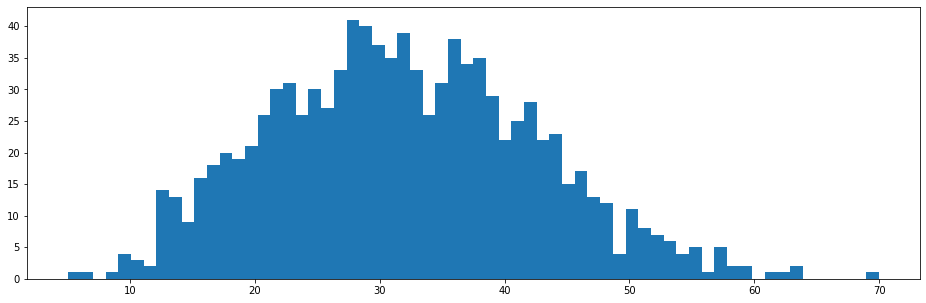

In [ ]:
#UTTERANCE LENGTH

print("Total number of utterances:", len(utt_lengths["duration"]["train"]))
print("Total number of frames:", np.sum(utt_lengths["duration"]["train"]))
hist(utt_lengths["duration"]["train"], bins=64);

Total number of utterances: 1000
Total number of frames: 534363


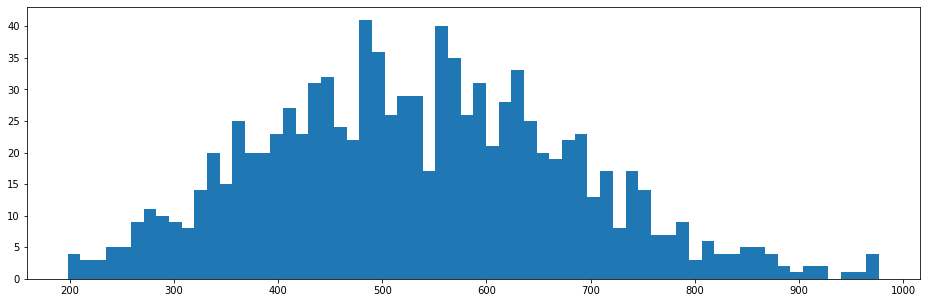

In [ ]:
print("Total number of utterances:", len(utt_lengths["acoustic"]["train"]))
print("Total number of frames:", np.sum(utt_lengths["acoustic"]["train"]))
hist(utt_lengths["acoustic"]["train"], bins=64);

Data Visualization 

In [ ]:
#HOW DATA LOOK LIKE?

def vis_utterance(X, Y, lengths, idx):
    """Visualize the following features:

    1. Linguistic features
    2. Spectrogram
    3. Log-F0
    4. Aperiodicity
    """
    x = X[idx][:lengths[idx]]
    y = Y[idx][:lengths[idx]]

    figure(figsize=(16,20))
    subplot(4,1,1)
    # haha, better than text?
    librosa.display.specshow(x.T, sr=fs, hop_length=hop_length, x_axis="time")

    subplot(4,1,2)
    logsp = np.log(pysptk.mc2sp(y[:,mgc_start_idx:mgc_dim//len(windows)], alpha=alpha, fftlen=fftlen))
    librosa.display.specshow(logsp.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")

    subplot(4,1,3)
    lf0 = y[:,mgc_start_idx]
    vuv = y[:,vuv_start_idx]
    plot(lf0, linewidth=2, label="Continuous log-f0")
    plot(vuv, linewidth=2, label="Voiced/unvoiced flag")
    legend(prop={"size": 14}, loc="upper right")

    subplot(4,1,4)
    bap = y[:,bap_start_idx:bap_start_idx+bap_dim//len(windows)]
    bap = np.ascontiguousarray(bap).astype(np.float64)
    aperiodicity = pyworld.decode_aperiodicity(bap, fs, fftlen)
    librosa.display.specshow(aperiodicity.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")

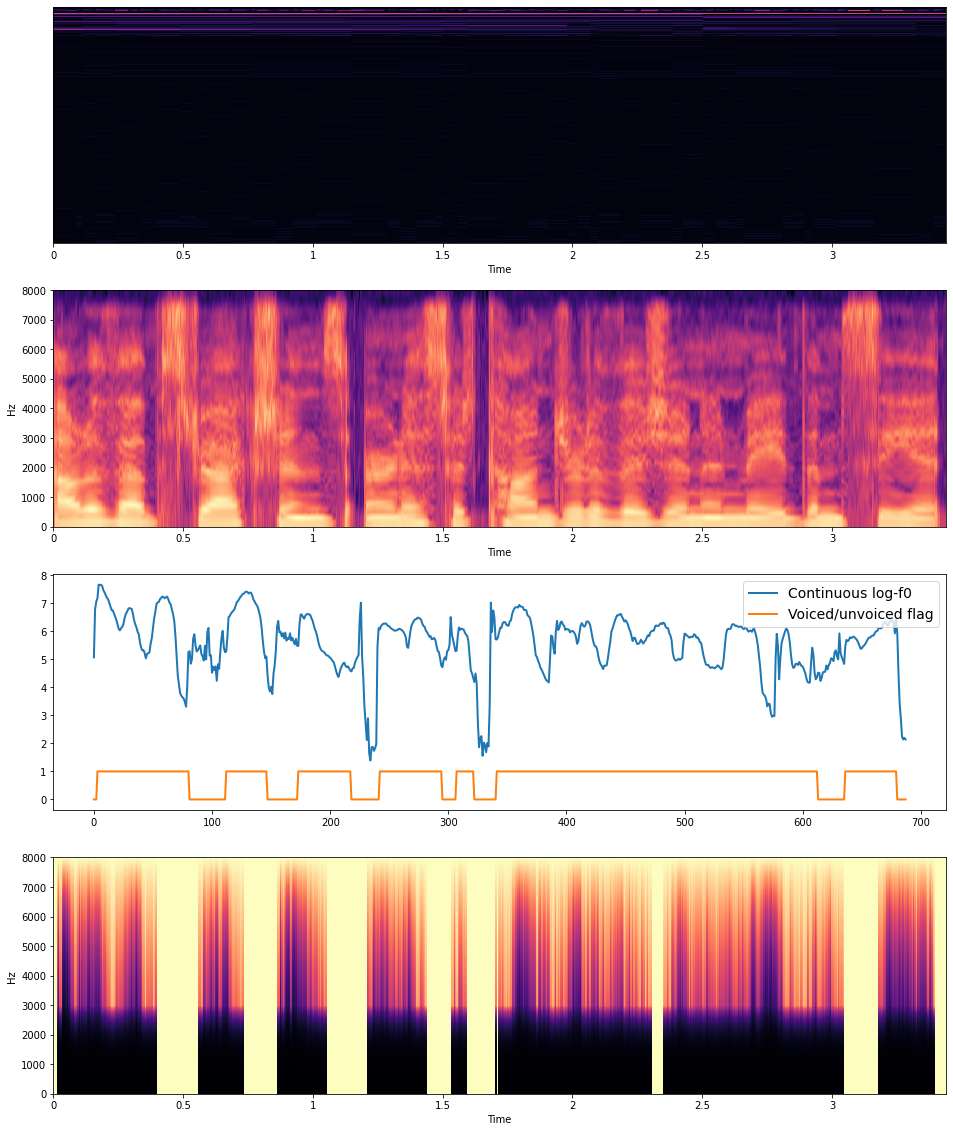

In [ ]:
idx = 0 # any
vis_utterance(X["acoustic"]["train"], Y["acoustic"]["train"], utt_lengths["acoustic"]["train"], idx)

Normalisation 

In [ ]:
#STATISTICS

X_min = {}
X_max = {}
Y_mean = {}
Y_var = {}
Y_scale = {}

for typ in ["acoustic", "duration"]:
    X_min[typ], X_max[typ] = minmax(X[typ]["train"], utt_lengths[typ]["train"])
    Y_mean[typ], Y_var[typ] = meanvar(Y[typ]["train"], utt_lengths[typ]["train"])
    Y_scale[typ] = np.sqrt(Y_var[typ])

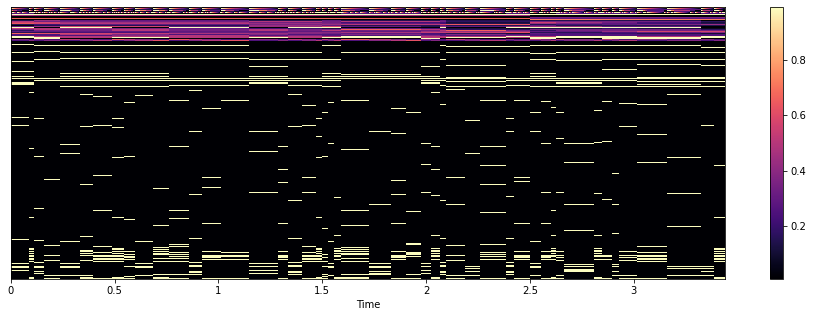

In [ ]:
idx = 0
typ = "acoustic"
x = X[typ]["train"][idx][:utt_lengths[typ]["train"][idx]]
x = minmax_scale(x, X_min[typ], X_max[typ], feature_range=(0.01, 0.99))
librosa.display.specshow(x.T, sr=fs, hop_length=hop_length, x_axis="time")
colorbar()

In [ ]:
#COMBINE DATASETS AND NORMALIZATION

from torch.utils import data as data_utils
import torch

class PyTorchDataset(torch.utils.data.Dataset):
    """Thin dataset wrapper for pytorch

    This does just two things:
        1. On-demand normalization
        2. Returns torch.FlaotTensor instead of numpy.ndarray
    """
    def __init__(self, X, Y, X_min, X_max, Y_mean, Y_scale):
        self.X, self.Y = X, Y
        self.X_min, self.X_max = X_min, X_max
        self.Y_mean, self.Y_scale = Y_mean, Y_scale
    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        x = minmax_scale(x, self.X_min, self.X_max, feature_range=(0.01, 0.99))
        y = scale(y, self.Y_mean, self.Y_scale)
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        return x, y
    def __len__(self):
        return len(self.X)

Model of DNN 

In [ ]:
#MODEL

import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tnrange, tqdm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

In [ ]:
class MyNet(torch.nn.Module):
    """Very simple deep neural networks.
    """
    def __init__(self, D_in, H, D_out, num_layers=2):
        super(MyNet, self).__init__()
        self.first_linear = nn.Linear(D_in, H)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(H, H) for _ in range(num_layers)])
        self.last_linear = nn.Linear(H, D_out)
        self.relu = nn.Tanh()

    def forward(self, x):
        h = self.relu(self.first_linear(x))
        for hl in self.hidden_layers:
            h = self.relu(hl(h))
        return self.last_linear(h)

Train 

In [ ]:
#TRAIN
#CONFIGURATION

num_hidden_layers = 3
hidden_size = 256
batch_size = 256
# We use PyTorch's multiprocess iterator. Note that large n_workers causes
# dataset copies across proccess.
n_workers = 4
pin_memory = True
nepoch = 25
lr = 0.001
weight_decay = 1e-6
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


Training Loop

In [ ]:
#TRAINING LOOP

def train(model, optimizer, X, Y, X_min, X_max, Y_mean, Y_scale,
          utt_lengths, cache_size=1000):
    if use_cuda:
        model = model.cuda()

    X_train, X_test = X["train"], X["test"]
    Y_train, Y_test = Y["train"], Y["test"]
    train_lengths, test_lengths = utt_lengths["train"], utt_lengths["test"]

    # Frame-wise train data loader
    X_train_cache_dataset = MemoryCacheFramewiseDataset(
        X_train, train_lengths, cache_size)
    Y_train_cache_dataset = MemoryCacheFramewiseDataset(
        Y_train, train_lengths, cache_size)
    train_dataset = PyTorchDataset(X_train_cache_dataset, Y_train_cache_dataset,
                                  X_min, X_max, Y_mean, Y_scale)
    train_loader = data_utils.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=n_workers,
        pin_memory=pin_memory, shuffle=True)
    print("Train dataset number of frames", len(train_dataset))

    # Frame-wise test data loader
    X_test_cache_dataset = MemoryCacheFramewiseDataset(
        X_test, test_lengths, cache_size)
    Y_test_cache_dataset = MemoryCacheFramewiseDataset(
        Y_test, test_lengths, cache_size)
    test_dataset = PyTorchDataset(X_test_cache_dataset, Y_test_cache_dataset,
                                 X_min, X_max, Y_mean, Y_scale)
    test_loader = data_utils.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=n_workers,
        pin_memory=pin_memory, shuffle=False)
    print("Test dataset numer of frames", len(test_dataset))

    dataset_loaders = {"train": train_loader, "test": test_loader}

    # Training loop
    criterion = nn.MSELoss()
    model.train()
    print("Start frame-wise training...")
    loss_history = {"train": [], "test": []}
    for epoch in tnrange(nepoch):
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for x, y in dataset_loaders[phase]:
                if use_cuda:
                    x, y = x.cuda(), y.cuda()
                x, y = Variable(x), Variable(y)
                optimizer.zero_grad()
                y_hat = model(x)
                loss = criterion(y_hat, y)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
            loss_history[phase].append(running_loss / len(dataset_loaders[phase]))

    return loss_history

In [ ]:
#DEFINE MODEL

models = {}
for typ in ["duration", "acoustic"]:
    models[typ] = MyNet(X[typ]["train"][0].shape[-1],
                            hidden_size, Y[typ]["train"][0].shape[-1],
                            num_hidden_layers)
    print("Model for {}\n".format(typ), models[typ])

Model for duration
 MyNet(
  (first_linear): Linear(in_features=416, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (last_linear): Linear(in_features=256, out_features=5, bias=True)
  (relu): Tanh()
)
Model for acoustic
 MyNet(
  (first_linear): Linear(in_features=425, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (last_linear): Linear(in_features=256, out_features=187, bias=True)
  (relu): Tanh()
)


Training Duration Model 

In [ ]:
#TRAINING DURATION MODEL
ty = "duration"
optimizer = optim.Adam(models[ty].parameters(), lr=lr, weight_decay=weight_decay)
loss_history = train(models[ty], optimizer, X[ty], Y[ty],
                     X_min[ty], X_max[ty], Y_mean[ty], Y_scale[ty], utt_lengths[ty])

Train dataset number of frames 32006
Test dataset numer of frames 4122
Start frame-wise training...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/25 [00:00<?, ?it/s]

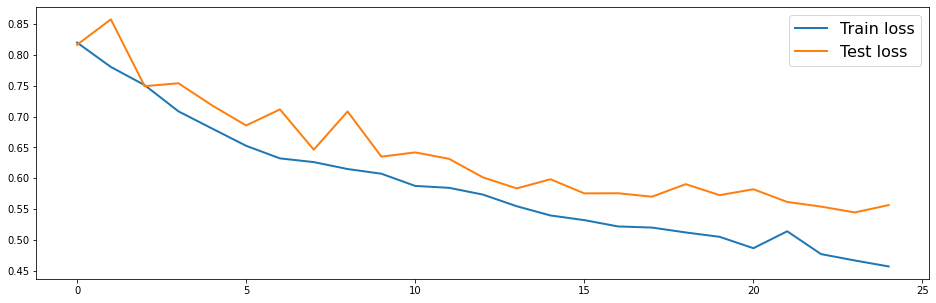

In [ ]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})

Training Acoustic Model 

In [ ]:
#TRAINING ACOUSTIC MODEL
ty = "acoustic"
optimizer = optim.Adam(models[ty].parameters(), lr=lr, weight_decay=weight_decay)
loss_history = train(models[ty], optimizer, X[ty], Y[ty],
                     X_min[ty], X_max[ty], Y_mean[ty], Y_scale[ty], utt_lengths[ty])

Train dataset number of frames 534363
Test dataset numer of frames 69249
Start frame-wise training...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/25 [00:00<?, ?it/s]

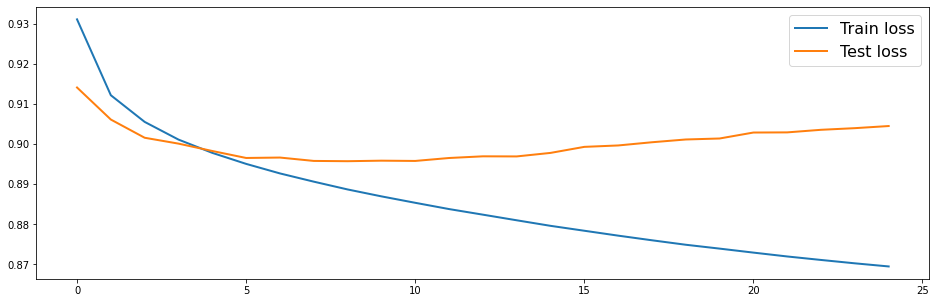

In [ ]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})

Test 

In [ ]:
#PARAMETER GENERATION UTILITIES

binary_dict, continuous_dict = hts.load_question_set(
    join(DATA_ROOT, "questions-radio_dnn_416.hed"))

def gen_parameters(y_predicted):
    # Number of time frames
    T = y_predicted.shape[0]

    # Split acoustic features
    mgc = y_predicted[:,:lf0_start_idx]
    lf0 = y_predicted[:,lf0_start_idx:vuv_start_idx]
    vuv = y_predicted[:,vuv_start_idx]
    bap = y_predicted[:,bap_start_idx:]

    # Perform MLPG
    ty = "acoustic"
    mgc_variances = np.tile(Y_var[ty][:lf0_start_idx], (T, 1))
    mgc = paramgen.mlpg(mgc, mgc_variances, windows)
    lf0_variances = np.tile(Y_var[ty][lf0_start_idx:vuv_start_idx], (T,1))
    lf0 = paramgen.mlpg(lf0, lf0_variances, windows)
    bap_variances = np.tile(Y_var[ty][bap_start_idx:], (T, 1))
    bap = paramgen.mlpg(bap, bap_variances, windows)

    return mgc, lf0, vuv, bap

def gen_waveform(y_predicted, do_postfilter=False):
    y_predicted = trim_zeros_frames(y_predicted)

    # Generate parameters and split streams
    mgc, lf0, vuv, bap = gen_parameters(y_predicted)

    if do_postfilter:
        mgc = merlin_post_filter(mgc, alpha)

    spectrogram = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
    aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, fftlen)
    f0 = lf0.copy()
    f0[vuv < 0.5] = 0
    f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

    generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                            spectrogram.astype(np.float64),
                                            aperiodicity.astype(np.float64),
                                            fs, frame_period)
    return generated_waveform

def gen_duration(label_path, duration_model):
    # Linguistic features for duration
    hts_labels = hts.load(label_path)
    duration_linguistic_features = fe.linguistic_features(hts_labels,
                                               binary_dict, continuous_dict,
                                               add_frame_features=False,
                                               subphone_features=None).astype(np.float32)

    # Apply normalization
    ty = "duration"
    duration_linguistic_features = minmax_scale(
        duration_linguistic_features, X_min[ty], X_max[ty], feature_range=(0.01, 0.99))

    # Apply model
    duration_model = duration_model.cpu()
    duration_model.eval()
    x = Variable(torch.from_numpy(duration_linguistic_features)).float()
    duration_predicted = duration_model(x).data.numpy()

    # Apply denormalization
    duration_predicted = duration_predicted * Y_scale[ty] + Y_mean[ty]
    duration_predicted = np.round(duration_predicted)

    # Set minimum state duration to 1
    duration_predicted[duration_predicted <= 0] = 1
    hts_labels.set_durations(duration_predicted)

    return hts_labels


def test_one_utt(label_path, duration_model, acoustic_model, post_filter=True):
    # Predict durations
    duration_modified_hts_labels = gen_duration(label_path, duration_model)

    # Linguistic features
    linguistic_features = fe.linguistic_features(duration_modified_hts_labels,
                                                  binary_dict, continuous_dict,
                                                  add_frame_features=True,
                                                  subphone_features="full")
    # Trim silences
    indices = duration_modified_hts_labels.silence_frame_indices()
    linguistic_features = np.delete(linguistic_features, indices, axis=0)

    # Apply normalization
    ty = "acoustic"
    linguistic_features = minmax_scale(linguistic_features,
                                       X_min[ty], X_max[ty], feature_range=(0.01, 0.99))

    # Predict acoustic features
    acoustic_model = acoustic_model.cpu()
    acoustic_model.eval()
    x = Variable(torch.from_numpy(linguistic_features)).float()
    acoustic_predicted = acoustic_model(x).data.numpy()

    # Apply denormalization
    acoustic_predicted = acoustic_predicted * Y_scale[ty] + Y_mean[ty]

    return gen_waveform(acoustic_predicted, post_filter)

In [ ]:
#LISTEN GENERATION AUDIO

test_label_paths = sorted(glob(join(DATA_ROOT, "label_state_align/", "*.lab")))[::-1][:5][::-1]
merlin_generated_wav_files = sorted(glob(join("/content/nnmnkwii_gallery-master/generated/merlin_slt_arctic_full/*.wav")))

# Save generated wav files for later comparison
save_dir = join("/content/generated")
if not exists(save_dir):
    os.makedirs(save_dir)

for label_path, wav_path in zip(test_label_paths, merlin_generated_wav_files):
    print("MyNet")
    waveform = test_one_utt(label_path, models["duration"], models["acoustic"])
    wavfile.write(join(save_dir, basename(wav_path)), rate=fs, data=waveform)
    IPython.display.display(Audio(waveform, rate=fs))

    print("Merlin (slt_arctic_full, generated with default configurations)")
    fs, waveform = wavfile.read(wav_path)
    IPython.display.display(Audio(waveform, rate=fs))

MyNet


Merlin (slt_arctic_full, generated with default configurations)


MyNet


Merlin (slt_arctic_full, generated with default configurations)


MyNet


Merlin (slt_arctic_full, generated with default configurations)


MyNet


Merlin (slt_arctic_full, generated with default configurations)


MyNet


Merlin (slt_arctic_full, generated with default configurations)


In [ ]:
#RMSE
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read the data set
df = pd.read_csv(
    "/content/sample_data/california_housing_test.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

# Create train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)